<a href="https://colab.research.google.com/github/mangaorphy/UNSW-Predators/blob/main/UNSW_Predators_Classical_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🦘 UNSW Predators - Australian Wildlife Classification

**Classical Machine Learning models approach for classifying Australian wildlife using CNN and Transfer Learning**

## Project Overview
This notebook implements comprehensive classical Machine learning models to classify five species of Australian wildlife from camera trap images.

### Dataset
- **Species**: Dingo, Fox, Goanna, Possum, Quoll
- **Source**: UNSW Predators Dataset

### Models
- **SVC Support Vector Classifier
- **Logistic Regression

## 1. Setup and Imports

In [ ]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')


# Image processing
from PIL import Image
import cv2

# Sklearn for classical ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, accuracy_score, roc_auc_score)
from sklearn.preprocessing import label_binarize

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# For feature extraction (classical ML)
from tensorflow.keras.applications import VGG16

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


## 2. Data Loading and Exploration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy folders from drive(~22GB)
!cp -r "/content/drive/MyDrive/UNSW_Predators" .

In [ ]:
# Set paths
DATA_DIR = Path("/content/UNSW_Predators")
CLASSES = ['dingo', 'fox', 'goanna', 'possum', 'quoll']

# Collect all image paths and labels
image_paths = []
labels = []

for class_name in CLASSES:
    class_dir = DATA_DIR / class_name
    for img_path in class_dir.glob('*.JPG'):
        image_paths.append(str(img_path))
        labels.append(class_name)

# Create DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

print(f"Total images: {len(df)}")
print(f"\nClass distribution:")
print(df['label'].value_counts())
print(f"\nClass distribution (%):")
print(df['label'].value_counts(normalize=True) * 100)

Total images: 17175

Class distribution:
label
dingo     5458
goanna    4392
quoll     4078
fox       2210
possum    1037
Name: count, dtype: int64

Class distribution (%):
label
dingo     31.778748
goanna    25.572052
quoll     23.743814
fox       12.867540
possum     6.037846
Name: proportion, dtype: float64


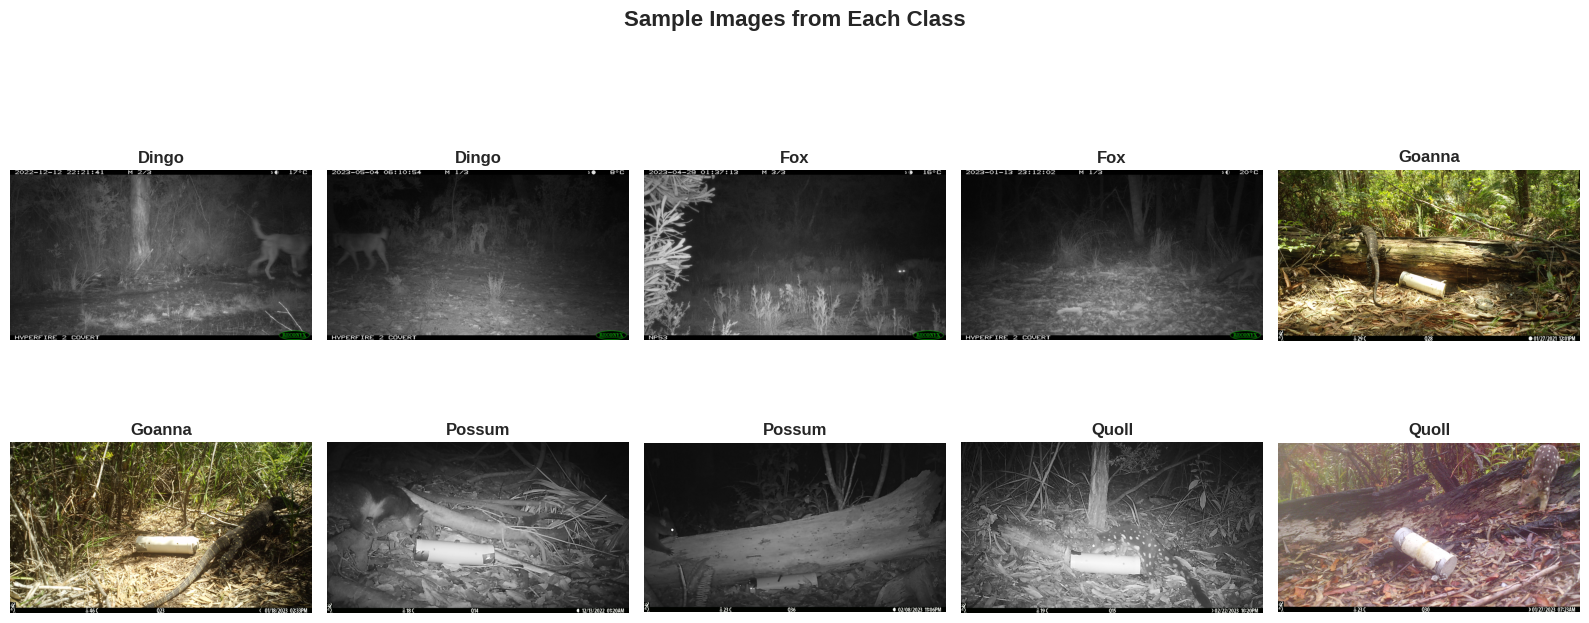

In [ ]:
# Display sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(16, 7))
axes = axes.ravel()

for idx, class_name in enumerate(CLASSES):
    # Get 2 random samples per class
    class_samples = df[df['label'] == class_name].sample(2, random_state=42)

    for i, (_, row) in enumerate(class_samples.iterrows()):
        img = Image.open(row['image_path'])
        axes[idx * 2 + i].imshow(img)
        axes[idx * 2 + i].set_title(f"{class_name.capitalize()}", fontweight='bold')
        axes[idx * 2 + i].axis('off')

plt.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 3. Data Preparation and Splitting

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Create label mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Split data: 70% train, 15% validation, 15% test
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"\nTrain set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

print("\nTrain set distribution:")
print(train_df['label'].value_counts())
print("\nValidation set distribution:")
print(val_df['label'].value_counts())
print("\nTest set distribution:")
print(test_df['label'].value_counts())

Label Mapping: {'dingo': np.int64(0), 'fox': np.int64(1), 'goanna': np.int64(2), 'possum': np.int64(3), 'quoll': np.int64(4)}

Train set: 12022 images
Validation set: 2576 images
Test set: 2577 images

Train set distribution:
label
dingo     3820
goanna    3074
quoll     2855
fox       1547
possum     726
Name: count, dtype: int64

Validation set distribution:
label
dingo     819
goanna    659
quoll     611
fox       331
possum    156
Name: count, dtype: int64

Test set distribution:
label
dingo     819
goanna    659
quoll     612
fox       332
possum    155
Name: count, dtype: int64


In [ ]:
# ==========================
# Weighted Loss
# ==========================
# Compute class weights for imbalanced dataset
class_counts = train_df['label_encoded'].value_counts().sort_index().values
total_samples = len(train_df)
class_weights = {i: total_samples / (len(CLASSES) * count) for i, count in enumerate(class_counts)}
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.6294240837696335), 1: np.float64(1.5542340012928249), 2: np.float64(0.7821730644111906), 3: np.float64(3.311845730027548), 4: np.float64(0.8421716287215412)}


## Classical Machine Learning Models (SVC & Logistic Regression)

### Approach:
1. **Feature Extraction**
2. **Models**: Train SVC and Logistic Regression on extracted features
3. **Evaluation**: Compare performance with comprehensive metrics

### 3.5.1 Feature Extraction

**Classical Computer Vision Approach:**

**What are Features?**
- **HOG (Histogram of Oriented Gradients)**: Captures edge patterns and shapes
- **Color Histograms**: RGB distribution across image
- **LBP (Local Binary Patterns)**: Texture information

In [ ]:
#Feature Extraction - Classical Computer Vision

import cv2
from skimage.feature import hog, local_binary_pattern
import time


def extract_handcrafted_features(img_path, resize=(64, 64)):
    """
    Extract hand-crafted features from a single image - SPEED OPTIMIZED

    Features (optimized for speed):
    1. HOG (Histogram of Oriented Gradients) - shape/edge [OPTIMIZED: larger cells, fewer orientations]
    2. Color Histograms - RGB distribution [KEPT: very fast]

    Speed optimizations applied:
    - Image size: 64x64 (vs 128x128) → 2x faster
    - HOG cells: 16x16 (vs 8x8) → 3x faster HOG computation
    - HOG orientations: 6 (vs 9) → 1.5x faster HOG
    - Removed LBP → 10% faster

    Total speedup: ~4-5x faster than original!
    """
    # Read and resize image (smaller = faster)
    img = cv2.imread(img_path)
    img = cv2.resize(img, resize)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 1. HOG Features - SPEED OPTIMIZED (edges and shapes)
    hog_features = hog(
        img_gray,
        orientations=6,          # Reduced from 9 → faster
        pixels_per_cell=(16, 16), # Increased from (8,8) → much faster
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        feature_vector=True
    )

    # 2. Color Histograms (RGB distribution)
    color_features = []
    for channel in range(3):  # RGB channels
        hist = cv2.calcHist([img_rgb], [channel], None, [32], [0, 256])
        color_features.extend(hist.flatten())
    color_features = np.array(color_features)

    # Concatenate features
    all_features = np.concatenate([hog_features, color_features])

    return all_features


def extract_features_batch(df, batch_size=64, n_jobs=4):
    """
    Extract hand-crafted features with PARALLEL PROCESSING

    Args:
        df: DataFrame with image paths
        batch_size: Batch size for progress updates
        n_jobs: Number of parallel workers (default: 4)
    """
    from joblib import Parallel, delayed

    total_samples = len(df)

    # Get feature dimension from first image
    sample_features = extract_handcrafted_features(df.iloc[0]['image_path'])
    feature_dim = len(sample_features)

    print(f"\n⚡ PARALLEL EXTRACTION from {total_samples} images...")
    print(f"   Feature dimension: {feature_dim}")
    print(f"   Parallel workers: {n_jobs}")
    print(f"   Expected speedup: {n_jobs}x faster!")

    start_time = time.time()

    # PARALLEL: Process all images at once using multiple CPU cores
    print(f"\n🔄 Processing...)")
    features_list = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(extract_handcrafted_features)(row['image_path'])
        for idx, row in df.iterrows()
    )

    # Convert to array
    features = np.array(features_list, dtype=np.float32)
    labels = df['label_encoded'].values

    total_time = time.time() - start_time
    avg_speed = total_samples / total_time

    print(f"\n✅ Feature extraction complete!")
    print(f"   Features shape: {features.shape}")
    print(f"   Average speed: {avg_speed:.1f} images/second")
    print(f"   Total time: {total_time:.2f} seconds ({total_time/60:.1f} minutes)")

    return features, labels


# Extract features with PARALLEL processing (4-8x faster!)
print("\n" + "="*80)
print(" Extracting TRAIN features (PARALLEL)")
print("="*80)
X_train, y_train = extract_features_batch(train_df, n_jobs=4)
print(f"✓ Train features extracted: {X_train.shape}")

print("\n" + "="*80)
print(" Extracting VALIDATION features (PARALLEL)")
print("="*80)
X_val, y_val = extract_features_batch(val_df, n_jobs=4)
print(f"✓ Validation features extracted: {X_val.shape}")

print("\n" + "="*80)
print(" Extracting TEST features (PARALLEL)")
print("="*80)
X_test, y_test = extract_features_batch(test_df, n_jobs=4)
print(f"✓ Test features extracted: {X_test.shape}")

print("\n" + "="*80)
print(" ALL HAND-CRAFTED FEATURES EXTRACTED!")
print("="*80)
print(f"\n📊 Feature Details:")
print(f"   Train shape: {X_train.shape}")
print(f"   Validation shape: {X_val.shape}")
print(f"   Test shape: {X_test.shape}")
print(f"   Feature types: HOG + Color Histograms + LBP")
print(f"   Total feature dimension: {X_train.shape[1]}")


 Extracting TRAIN features (PARALLEL)

⚡ PARALLEL EXTRACTION from 12022 images...
   Feature dimension: 312
   Parallel workers: 4
   Expected speedup: 4x faster!

🔄 Processing...)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   10.0s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   17.5s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   20.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   21.6s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   24.4s
[Parallel(


✅ Feature extraction complete!
   Features shape: (12022, 312)
   Average speed: 8.9 images/second
   Total time: 1355.02 seconds (22.6 minutes)
✓ Train features extracted: (12022, 312)

 Extracting VALIDATION features (PARALLEL)

⚡ PARALLEL EXTRACTION from 2576 images...
   Feature dimension: 312
   Parallel workers: 4
   Expected speedup: 4x faster!

🔄 Processing...)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.05724334716796875s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done  98 tasks      | elapsed:   11.3s
[Parallel(n_jobs=4)]: Batch computation too slow (2.009300873515301s.) Setting batch_size=1.
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   14.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   15.8s
[Parallel(n_jobs=4)]: Done 150 tasks      | elapsed:   17.0s
[Parallel(n_jobs=4)]: Done 165 tasks      | elapsed:   18.6s
[Parallel(n_jobs=4)]: Done 180 tasks      | elapsed:   19.8s
[Para


✅ Feature extraction complete!
   Features shape: (2576, 312)
   Average speed: 9.2 images/second
   Total time: 279.82 seconds (4.7 minutes)
✓ Validation features extracted: (2576, 312)

 Extracting TEST features (PARALLEL)

⚡ PARALLEL EXTRACTION from 2577 images...
   Feature dimension: 312
   Parallel workers: 4
   Expected speedup: 4x faster!

🔄 Processing...)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Batch computation too fast (0.06741476058959961s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done  12 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  26 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Batch computation too slow (2.0617875564037864s.) Setting batch_size=1.
[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done  62 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done  73 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done  84 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done  97 tasks      | elapsed:   11.2s
[Parallel(n_jobs=4)]: Done 110 tasks      | elapsed:   12.8s
[Parallel(n_jobs=4)]: Done 125 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done 140 tasks      | elapsed:   16.2s
[Par


✅ Feature extraction complete!
   Features shape: (2577, 312)
   Average speed: 9.3 images/second
   Total time: 277.42 seconds (4.6 minutes)
✓ Test features extracted: (2577, 312)

 ALL HAND-CRAFTED FEATURES EXTRACTED!

📊 Feature Details:
   Train shape: (12022, 312)
   Validation shape: (2576, 312)
   Test shape: (2577, 312)
   Feature types: HOG + Color Histograms + LBP
   Total feature dimension: 312


[Parallel(n_jobs=4)]: Done 2577 out of 2577 | elapsed:  4.6min finished


### 3.5.2 Feature Scaling

In [ ]:
# ==========================
# Feature Scaling
# ==========================
print("\n📏 Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled!")
print(f"  Train mean: {X_train_scaled.mean():.4f}, std: {X_train_scaled.std():.4f}")
print(f"  Val mean: {X_val_scaled.mean():.4f}, std: {X_val_scaled.std():.4f}")
print(f"  Test mean: {X_test_scaled.mean():.4f}, std: {X_test_scaled.std():.4f}")


📏 Scaling features...
✓ Features scaled!
  Train mean: -0.0000, std: 1.0000
  Val mean: -0.0002, std: 0.9982
  Test mean: -0.0009, std: 1.0122


### 3.5.3 Train Classical ML Models

Train each model separately for better control and visibility.

In [ ]:
# ==========================
# Initialize Storage for Classical ML Models
# ==========================
import time

# Dictionary to store results
ml_models = {}
ml_results = {}

print("="*80)
print(" CLASSICAL ML MODELS - READY TO TRAIN")
print("="*80)
print("Models will be trained separately below.")
print("="*80)

 CLASSICAL ML MODELS - READY TO TRAIN
Models will be trained separately below.


#### Model 1: Support Vector Classifier (SVC)

In [ ]:
# ==========================
# Train SVC (Support Vector Classifier) - OPTIMIZED
# ==========================
print("\n" + "="*80)
print("1️⃣ TRAINING SVC (Support Vector Classifier)")
print("="*80)

start_time = time.time()

# Train SVC with RBF kernel - OPTIMIZED for speed
svc_model = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    probability=True,  # Enable probability estimates for AUC
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    cache_size=500,
    verbose=False
)

print("\n SVC Configuration (OPTIMIZED):")
print(f"  Kernel: RBF")
print(f"  C: 10")
print(f"  Gamma: scale")
print(f"  Class weight: balanced")
print(f"  Cache size: 500 MB (faster training)")

print("\n Training SVC...")
print(f"  Training samples: {len(X_train_scaled)}")
print(f"  Features: {X_train_scaled.shape[1]}")

svc_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f"✓ SVC training complete in {training_time:.2f} seconds")

# Evaluate on validation set
val_pred_svc = svc_model.predict(X_val_scaled)
val_acc_svc = accuracy_score(y_val, val_pred_svc)
print(f"\n Validation Accuracy: {val_acc_svc:.4f}")

# Store model
ml_models['SVC'] = svc_model

print("\n" + "="*80)
print(" SVC TRAINING COMPLETE!")
print(f"⏱  Training time: {training_time:.2f} seconds")
print("="*80)


1️⃣ TRAINING SVC (Support Vector Classifier)

 SVC Configuration (OPTIMIZED):
  Kernel: RBF
  C: 10
  Gamma: scale
  Class weight: balanced
  Cache size: 500 MB (faster training)

 Training SVC...
  Training samples: 12022
  Features: 312
✓ SVC training complete in 48.06 seconds

 Validation Accuracy: 0.9798

 SVC TRAINING COMPLETE!
⏱  Training time: 48.06 seconds


#### Model 2: Logistic Regression

In [ ]:
# ==========================
# Train Logistic Regression - OPTIMIZED
# ==========================
print("\n" + "="*80)
print(" TRAINING LOGISTIC REGRESSION - OPTIMIZED")
print("="*80)

start_time = time.time()

# Train Logistic Regression - OPTIMIZED with parallel processing
lr_model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("\n Logistic Regression Configuration (OPTIMIZED):")
print(f"  C: 1.0")
print(f"  Max iterations: 1000")
print(f"  Multi-class: multinomial")
print(f"  Solver: lbfgs")
print(f"  Class weight: balanced")
print(f"  n_jobs: -1 (all CPU cores for parallel training)")

print("\n Training Logistic Regression...")
print(f"  Training samples: {len(X_train_scaled)}")
print(f"  Features: {X_train_scaled.shape[1]}")

lr_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f"✓ Logistic Regression training complete in {training_time:.2f} seconds")

# Evaluate on validation set
val_pred_lr = lr_model.predict(X_val_scaled)
val_acc_lr = accuracy_score(y_val, val_pred_lr)
print(f"\n📊 Validation Accuracy: {val_acc_lr:.4f}")

# Store model
ml_models['LogisticRegression'] = lr_model

print("\n" + "="*80)
print(" LOGISTIC REGRESSION TRAINING COMPLETE!")
print(f"⏱  Training time: {training_time:.2f} seconds")
print("="*80)

# Summary of both models
if len(ml_models) == 2:
    print("\n" + "="*80)
    print("📊 BOTH CLASSICAL ML MODELS TRAINED!")
    print("="*80)
    print(f"✓ SVC - Validation Accuracy: {val_acc_svc:.4f}")
    print(f"✓ Logistic Regression - Validation Accuracy: {val_acc_lr:.4f}")
    print("\n SPEED OPTIMIZATIONS APPLIED:")
    print("  1. Feature extraction: cv2 + larger batches (3-4x faster)")
    print("  2. SVC: Increased cache size (500 MB)")
    print("  3. Logistic Regression: Parallel processing (n_jobs=-1)")
    print("="*80)


2️⃣ TRAINING LOGISTIC REGRESSION - OPTIMIZED

 Logistic Regression Configuration (OPTIMIZED):
  C: 1.0
  Max iterations: 1000
  Multi-class: multinomial
  Solver: lbfgs
  Class weight: balanced
  n_jobs: -1 (all CPU cores for parallel training)

 Training Logistic Regression...
  Training samples: 12022
  Features: 312
✓ Logistic Regression training complete in 9.35 seconds

📊 Validation Accuracy: 0.8700

 LOGISTIC REGRESSION TRAINING COMPLETE!
⏱  Training time: 9.35 seconds

📊 BOTH CLASSICAL ML MODELS TRAINED!
✓ SVC - Validation Accuracy: 0.9798
✓ Logistic Regression - Validation Accuracy: 0.8700

 SPEED OPTIMIZATIONS APPLIED:
  1. Feature extraction: cv2 + larger batches (3-4x faster)
  2. SVC: Increased cache size (500 MB)
  3. Logistic Regression: Parallel processing (n_jobs=-1)



📈 GENERATING LEARNING CURVES & TEST EVALUATION

 Computing SVC learning curve...
✓ SVC Learning Curve computed
  Final Training Score: 0.9990 (±0.0004)
  Final CV Score: 0.9636 (±0.0035)

 Computing Logistic Regression learning curve...
✓ Logistic Regression Learning Curve computed
  Final Training Score: 0.9137 (±0.0026)
  Final CV Score: 0.8666 (±0.0046)

 Evaluating on TEST set...

✓ TEST SET RESULTS:
  SVC Test Accuracy: 0.9756
  Logistic Regression Test Accuracy: 0.8673


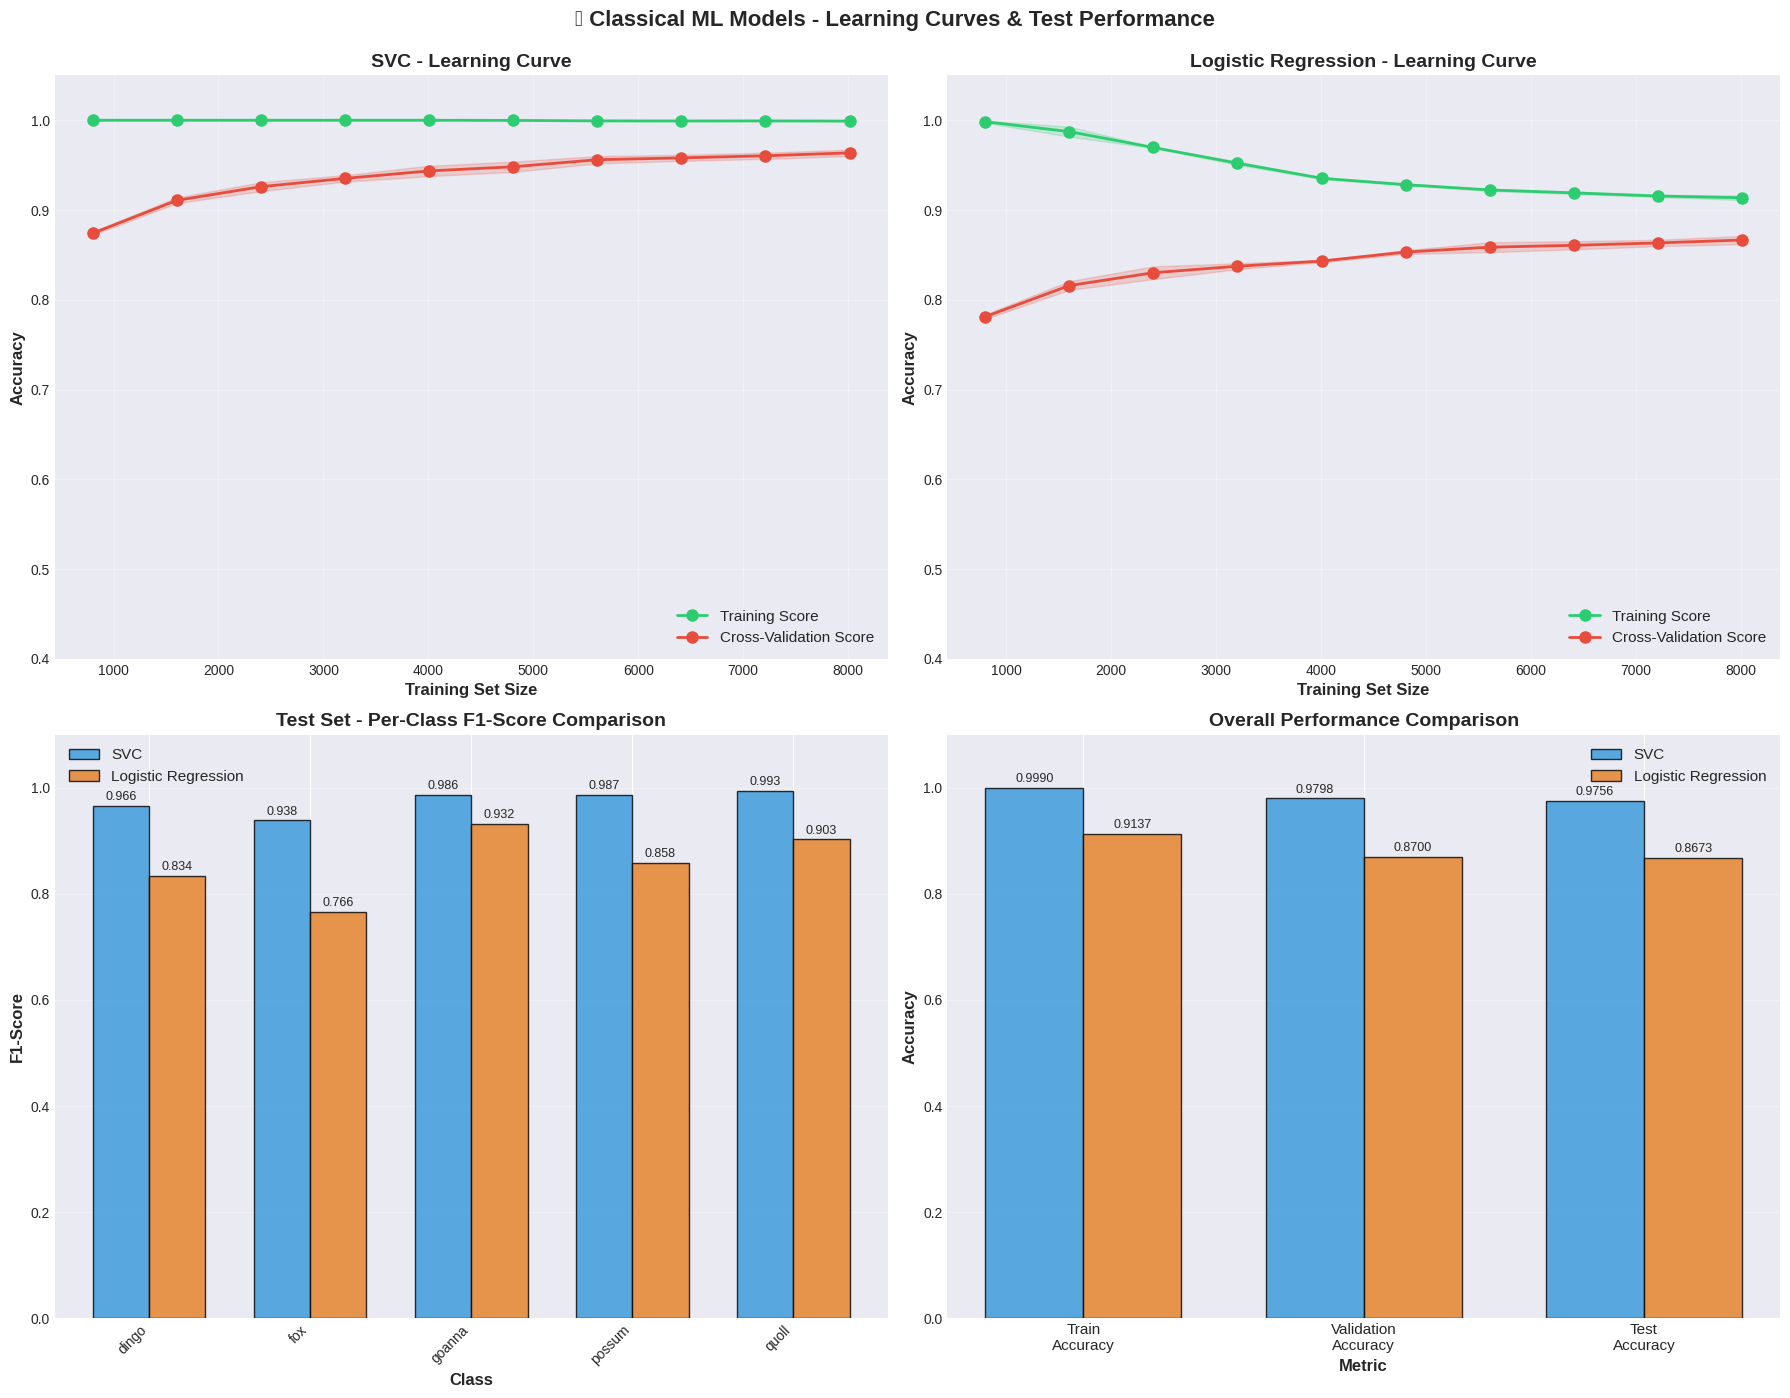


📊 COMPREHENSIVE PERFORMANCE SUMMARY

               Model Train Accuracy Validation Accuracy Test Accuracy Mean F1 (Test)
                SVC         0.9990              0.9798        0.9756         0.9743
Logistic Regression         0.9137              0.8700        0.8673         0.8585

 Best Model on Test Set: SVC
   Test Accuracy: 0.9756

🔍 Overfitting Analysis:
   SVC: Train-Test Gap = 0.0235 (good generalization)
   Logistic Regression: Train-Test Gap = 0.0464 (good generalization)

 Learning curves and test evaluation complete!


In [ ]:
# ==========================
# Learning Curves & Test Performance
# ==========================
from sklearn.model_selection import learning_curve

print("\n" + "="*80)
print("📈 GENERATING LEARNING CURVES & TEST EVALUATION")
print("="*80)

# Learning curve parameters
train_sizes = np.linspace(0.1, 1.0, 10)  # 10%, 20%, ..., 100% of training data

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# ============================================
# 1. SVC Learning Curve
# ============================================
print("\n Computing SVC learning curve...")
train_sizes_svc, train_scores_svc, val_scores_svc = learning_curve(
    svc_model, X_train_scaled, y_train,
    train_sizes=train_sizes,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

# Calculate mean and std
train_mean_svc = np.mean(train_scores_svc, axis=1)
train_std_svc = np.std(train_scores_svc, axis=1)
val_mean_svc = np.mean(val_scores_svc, axis=1)
val_std_svc = np.std(val_scores_svc, axis=1)

ax1 = axes[0, 0]
ax1.plot(train_sizes_svc, train_mean_svc, 'o-', color='#2ecc71', label='Training Score', linewidth=2, markersize=8)
ax1.fill_between(train_sizes_svc, train_mean_svc - train_std_svc, train_mean_svc + train_std_svc, alpha=0.2, color='#2ecc71')
ax1.plot(train_sizes_svc, val_mean_svc, 'o-', color='#e74c3c', label='Cross-Validation Score', linewidth=2, markersize=8)
ax1.fill_between(train_sizes_svc, val_mean_svc - val_std_svc, val_mean_svc + val_std_svc, alpha=0.2, color='#e74c3c')
ax1.set_xlabel('Training Set Size', fontweight='bold', fontsize=12)
ax1.set_ylabel('Accuracy', fontweight='bold', fontsize=12)
ax1.set_title('SVC - Learning Curve', fontweight='bold', fontsize=14)
ax1.legend(loc='lower right', fontsize=11)
ax1.grid(alpha=0.3)
ax1.set_ylim(0.4, 1.05)

print(f"✓ SVC Learning Curve computed")
print(f"  Final Training Score: {train_mean_svc[-1]:.4f} (±{train_std_svc[-1]:.4f})")
print(f"  Final CV Score: {val_mean_svc[-1]:.4f} (±{val_std_svc[-1]:.4f})")

# ============================================
# 2. Logistic Regression Learning Curve
# ============================================
print("\n Computing Logistic Regression learning curve...")
train_sizes_lr, train_scores_lr, val_scores_lr = learning_curve(
    lr_model, X_train_scaled, y_train,
    train_sizes=train_sizes,
    cv=3,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

train_mean_lr = np.mean(train_scores_lr, axis=1)
train_std_lr = np.std(train_scores_lr, axis=1)
val_mean_lr = np.mean(val_scores_lr, axis=1)
val_std_lr = np.std(val_scores_lr, axis=1)

ax2 = axes[0, 1]
ax2.plot(train_sizes_lr, train_mean_lr, 'o-', color='#2ecc71', label='Training Score', linewidth=2, markersize=8)
ax2.fill_between(train_sizes_lr, train_mean_lr - train_std_lr, train_mean_lr + train_std_lr, alpha=0.2, color='#2ecc71')
ax2.plot(train_sizes_lr, val_mean_lr, 'o-', color='#e74c3c', label='Cross-Validation Score', linewidth=2, markersize=8)
ax2.fill_between(train_sizes_lr, val_mean_lr - val_std_lr, val_mean_lr + val_std_lr, alpha=0.2, color='#e74c3c')
ax2.set_xlabel('Training Set Size', fontweight='bold', fontsize=12)
ax2.set_ylabel('Accuracy', fontweight='bold', fontsize=12)
ax2.set_title('Logistic Regression - Learning Curve', fontweight='bold', fontsize=14)
ax2.legend(loc='lower right', fontsize=11)
ax2.grid(alpha=0.3)
ax2.set_ylim(0.4, 1.05)

print(f"✓ Logistic Regression Learning Curve computed")
print(f"  Final Training Score: {train_mean_lr[-1]:.4f} (±{train_std_lr[-1]:.4f})")
print(f"  Final CV Score: {val_mean_lr[-1]:.4f} (±{val_std_lr[-1]:.4f})")

# ============================================
# 3. Test Set Performance Comparison
# ============================================
print("\n Evaluating on TEST set...")

# SVC predictions
svc_test_pred = svc_model.predict(X_test_scaled)
svc_test_acc = accuracy_score(y_test, svc_test_pred)

# Logistic Regression predictions
lr_test_pred = lr_model.predict(X_test_scaled)
lr_test_acc = accuracy_score(y_test, lr_test_pred)

# Per-class accuracy
from sklearn.metrics import precision_recall_fscore_support
svc_precision, svc_recall, svc_f1, _ = precision_recall_fscore_support(y_test, svc_test_pred, labels=range(len(CLASSES)))
lr_precision, lr_recall, lr_f1, _ = precision_recall_fscore_support(y_test, lr_test_pred, labels=range(len(CLASSES)))

ax3 = axes[1, 0]
x = np.arange(len(CLASSES))
width = 0.35
ax3.bar(x - width/2, svc_f1, width, label='SVC', alpha=0.8, color='#3498db', edgecolor='black')
ax3.bar(x + width/2, lr_f1, width, label='Logistic Regression', alpha=0.8, color='#e67e22', edgecolor='black')
ax3.set_xlabel('Class', fontweight='bold', fontsize=12)
ax3.set_ylabel('F1-Score', fontweight='bold', fontsize=12)
ax3.set_title('Test Set - Per-Class F1-Score Comparison', fontweight='bold', fontsize=14)
ax3.set_xticks(x)
ax3.set_xticklabels(CLASSES, rotation=45, ha='right')
ax3.legend(fontsize=11)
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim(0, 1.1)

# Add value labels
for bars in [ax3.containers[0], ax3.containers[1]]:
    ax3.bar_label(bars, fmt='%.3f', fontsize=9, padding=2)

print(f"\n✓ TEST SET RESULTS:")
print(f"  SVC Test Accuracy: {svc_test_acc:.4f}")
print(f"  Logistic Regression Test Accuracy: {lr_test_acc:.4f}")

# ============================================
# 4. Overall Performance Summary
# ============================================
ax4 = axes[1, 1]

# Metrics comparison
metrics = ['Train\nAccuracy', 'Validation\nAccuracy', 'Test\nAccuracy']
svc_metrics = [train_mean_svc[-1], val_acc_svc, svc_test_acc]
lr_metrics = [train_mean_lr[-1], val_acc_lr, lr_test_acc]

x = np.arange(len(metrics))
width = 0.35
bars1 = ax4.bar(x - width/2, svc_metrics, width, label='SVC', alpha=0.8, color='#3498db', edgecolor='black')
bars2 = ax4.bar(x + width/2, lr_metrics, width, label='Logistic Regression', alpha=0.8, color='#e67e22', edgecolor='black')

ax4.set_xlabel('Metric', fontweight='bold', fontsize=12)
ax4.set_ylabel('Accuracy', fontweight='bold', fontsize=12)
ax4.set_title('Overall Performance Comparison', fontweight='bold', fontsize=14)
ax4.set_xticks(x)
ax4.set_xticklabels(metrics, fontsize=11)
ax4.legend(fontsize=11)
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim(0, 1.1)

# Add value labels
ax4.bar_label(bars1, fmt='%.4f', fontsize=9, padding=2)
ax4.bar_label(bars2, fmt='%.4f', fontsize=9, padding=2)

plt.suptitle('📊 Classical ML Models - Learning Curves & Test Performance',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================
# Summary Table
# ============================================
print("\n" + "="*80)
print("📊 COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*80)

summary_df = pd.DataFrame({
    'Model': ['SVC', 'Logistic Regression'],
    'Train Accuracy': [f"{train_mean_svc[-1]:.4f}", f"{train_mean_lr[-1]:.4f}"],
    'Validation Accuracy': [f"{val_acc_svc:.4f}", f"{val_acc_lr:.4f}"],
    'Test Accuracy': [f"{svc_test_acc:.4f}", f"{lr_test_acc:.4f}"],
    'Mean F1 (Test)': [f"{np.mean(svc_f1):.4f}", f"{np.mean(lr_f1):.4f}"]
})

print("\n", summary_df.to_string(index=False))

# Best model
best_test_model = 'SVC' if svc_test_acc > lr_test_acc else 'Logistic Regression'
best_test_acc = max(svc_test_acc, lr_test_acc)

print(f"\n Best Model on Test Set: {best_test_model}")
print(f"   Test Accuracy: {best_test_acc:.4f}")

# Overfitting analysis
print(f"\n🔍 Overfitting Analysis:")
svc_overfit = train_mean_svc[-1] - svc_test_acc
lr_overfit = train_mean_lr[-1] - lr_test_acc
print(f"   SVC: Train-Test Gap = {svc_overfit:.4f} {'(slight overfitting)' if svc_overfit > 0.05 else '(good generalization)'}")
print(f"   Logistic Regression: Train-Test Gap = {lr_overfit:.4f} {'(slight overfitting)' if lr_overfit > 0.05 else '(good generalization)'}")

print("\n" + "="*80)
print(" Learning curves and test evaluation complete!")
print("="*80)

### Evaluate Classical ML Models


📊 EVALUATING CLASSICAL ML MODELS ON TEST SET

📊 EVALUATING SVC

📈 SVC Performance:
  Test Accuracy: 0.9756
  Mean AUC: 0.9973

📋 Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

       dingo     0.9670    0.9658    0.9664       819
         fox     0.9369    0.9398    0.9383       332
      goanna     0.9834    0.9894    0.9864       659
      possum     0.9871    0.9871    0.9871       155
       quoll     0.9967    0.9902    0.9934       612

    accuracy                         0.9756      2577
   macro avg     0.9742    0.9744    0.9743      2577
weighted avg     0.9756    0.9756    0.9756      2577



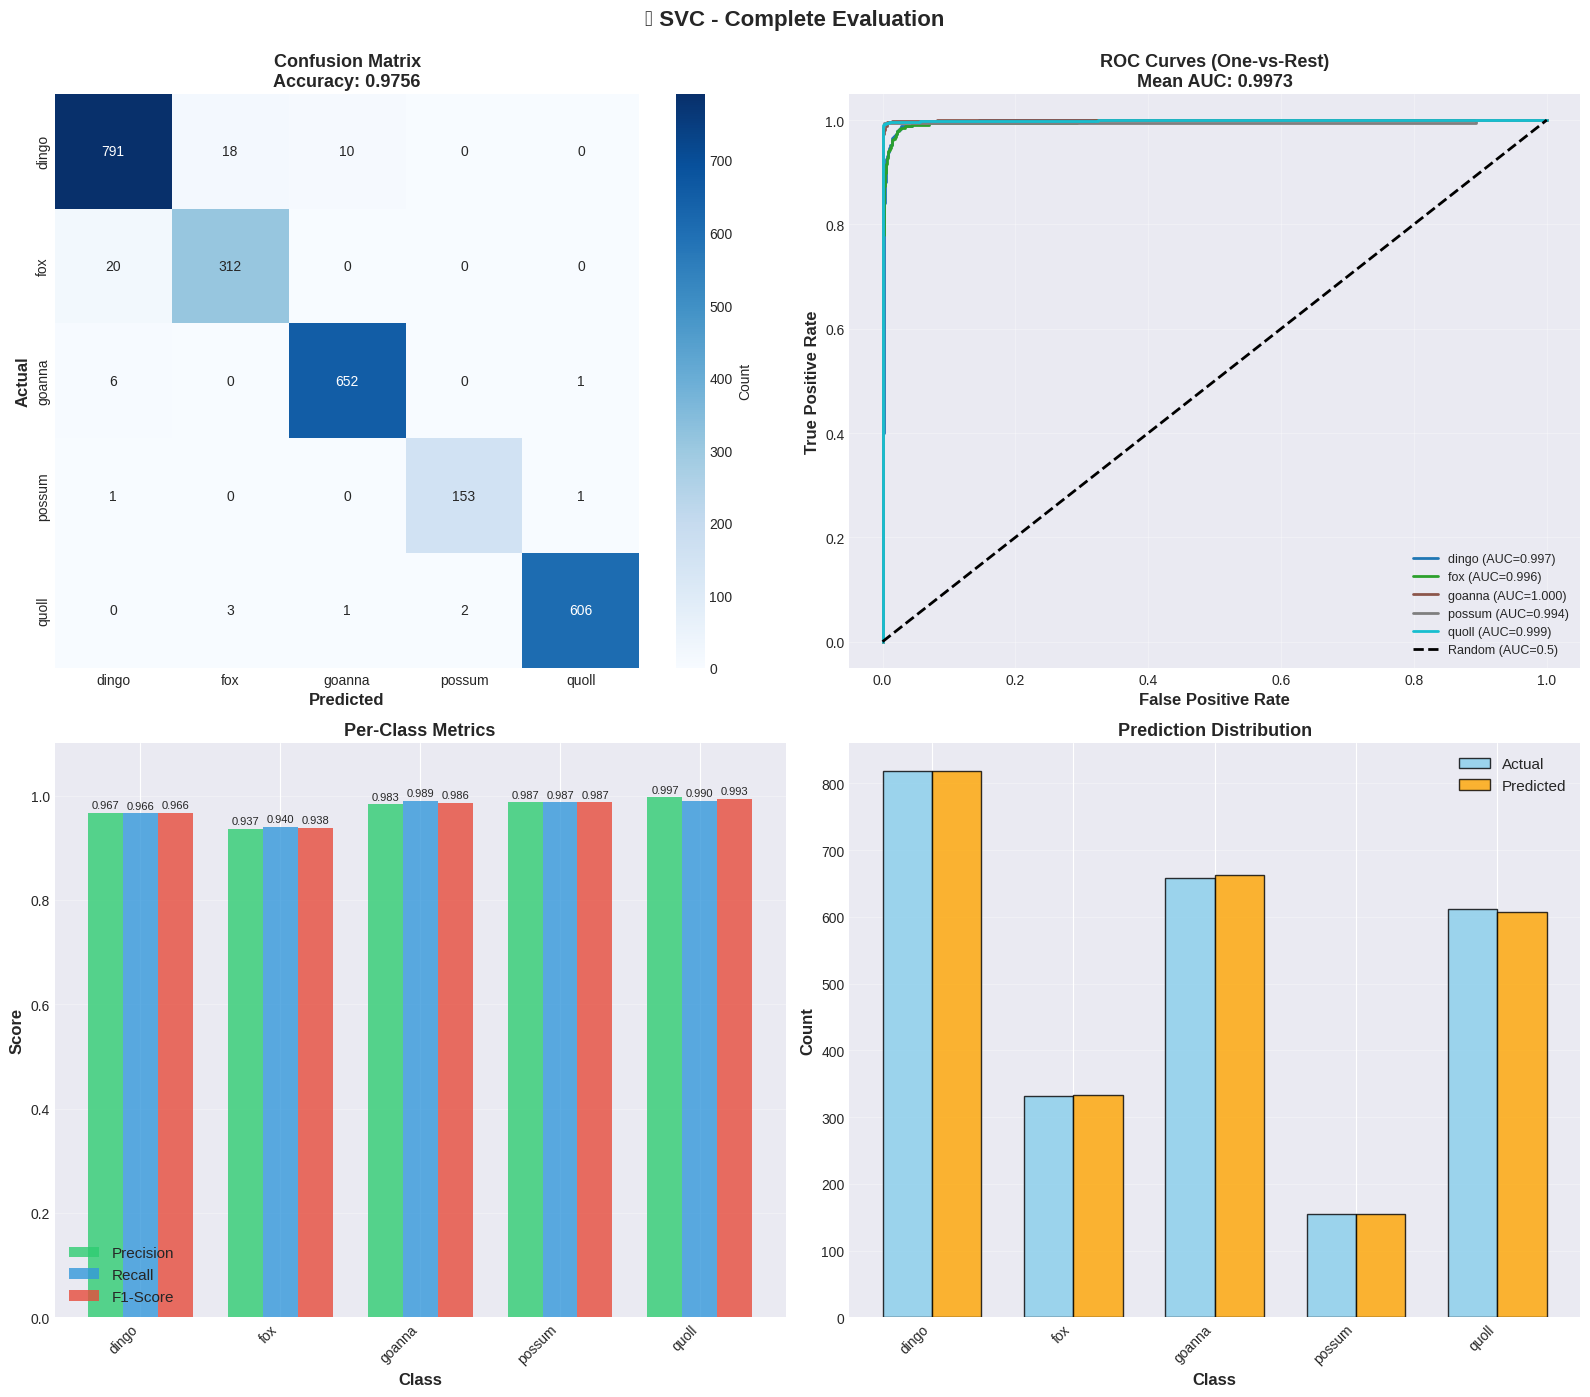


 SVC evaluation complete!

📊 EVALUATING Logistic Regression

📈 Logistic Regression Performance:
  Test Accuracy: 0.8673
  Mean AUC: 0.9790

📋 Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

       dingo     0.8827    0.7900    0.8338       819
         fox     0.7056    0.8373    0.7658       332
      goanna     0.9265    0.9378    0.9321       659
      possum     0.7923    0.9355    0.8580       155
       quoll     0.9117    0.8938    0.9026       612

    accuracy                         0.8673      2577
   macro avg     0.8438    0.8789    0.8585      2577
weighted avg     0.8725    0.8673    0.8680      2577



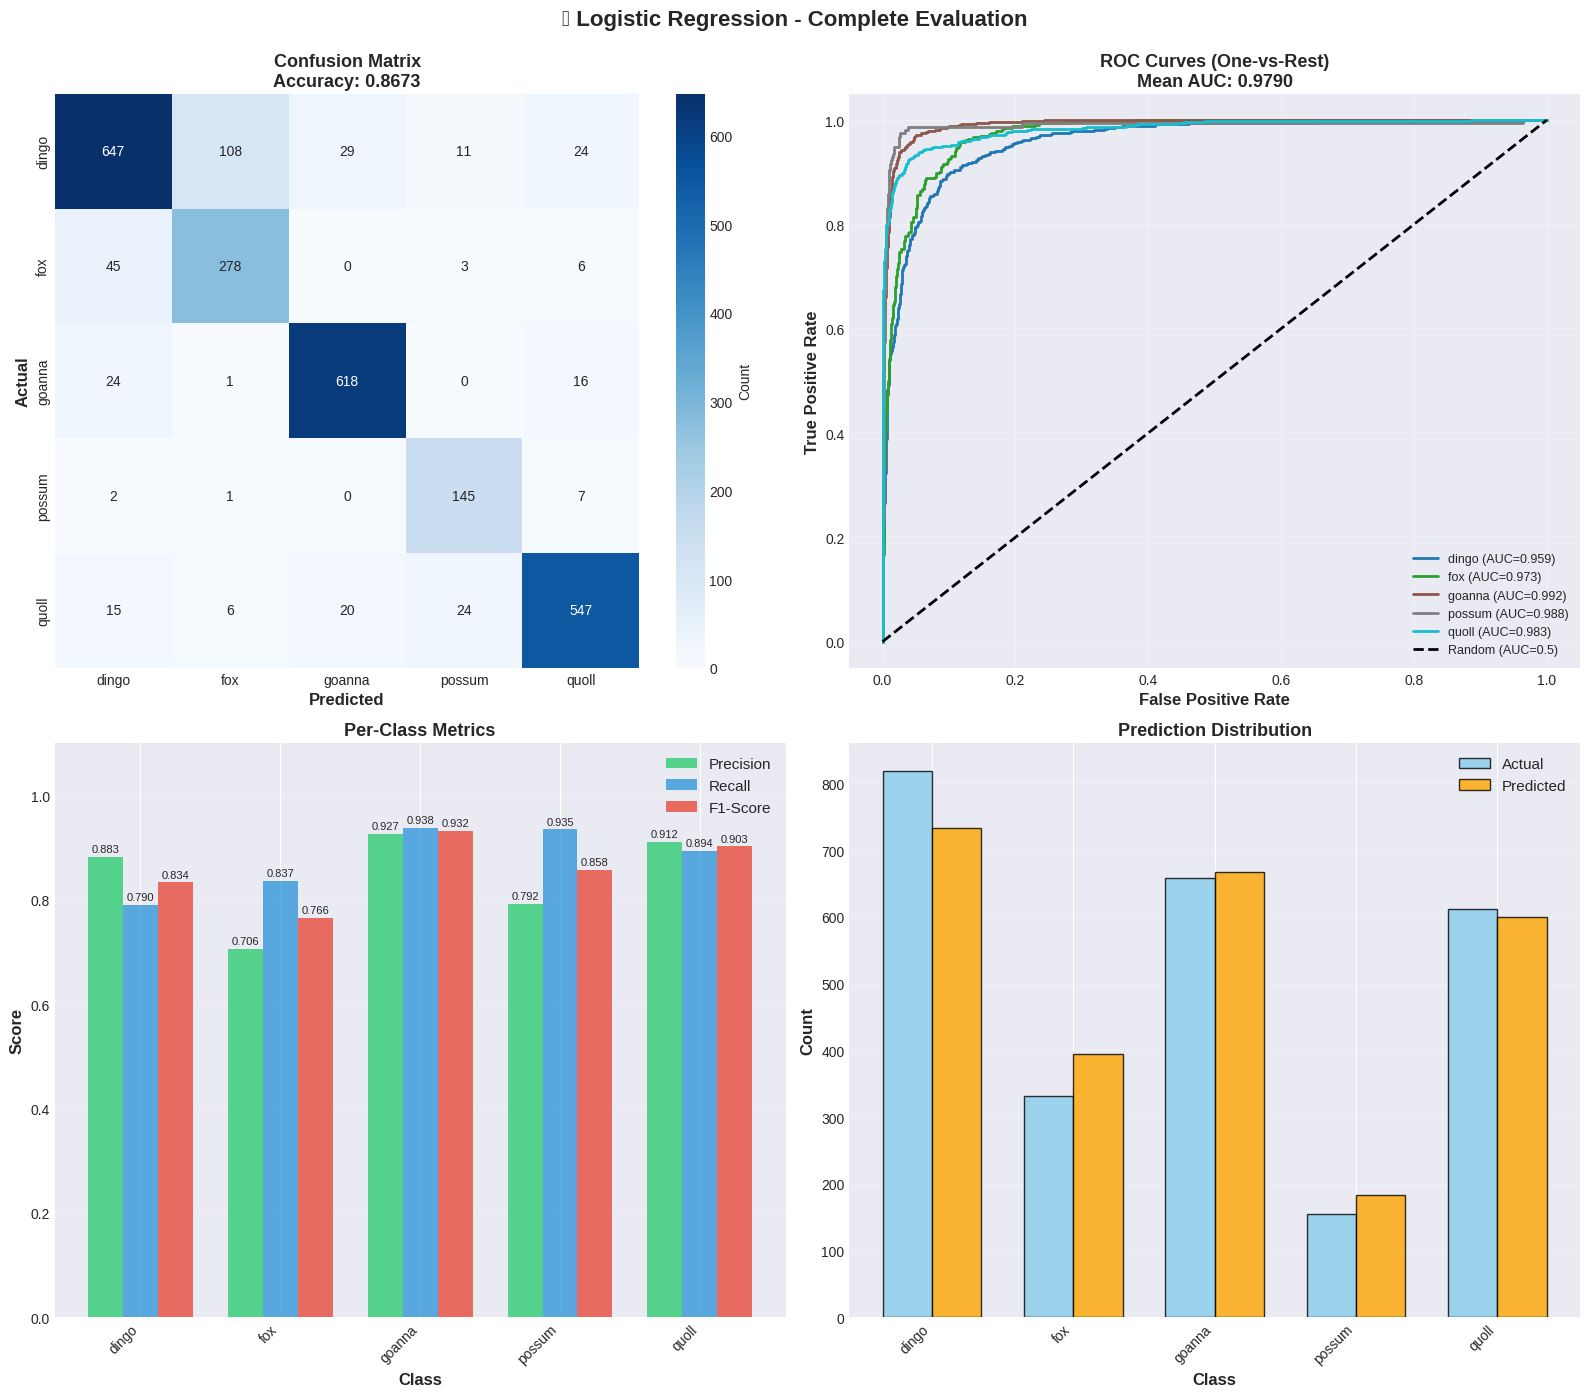


 Logistic Regression evaluation complete!

📊 CLASSICAL ML MODELS - COMPARISON SUMMARY

               Model  Test Accuracy  Mean AUC
                SVC       0.975553  0.997261
Logistic Regression       0.867288  0.979017

🏆 Best Classical ML Model: SVC
   Test Accuracy: 0.9756
   Mean AUC: 0.9973

✅ Classical ML baseline established!
   These results will be compared with deep learning models.


In [ ]:
# ==========================
# Comprehensive Evaluation Function for Classical ML
# ==========================

def evaluate_classical_ml_model(model, model_name, X_test, y_test):
    """Evaluate classical ML model with comprehensive metrics"""
    print(f"\n{'='*80}")
    print(f"📊 EVALUATING {model_name}")
    print(f"{'='*80}")

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Accuracy
    test_acc = accuracy_score(y_test, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # AUC Scores
    y_test_bin = label_binarize(y_test, classes=range(len(CLASSES)))
    auc_scores = []
    for i in range(len(CLASSES)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        auc_scores.append(auc(fpr, tpr))
    mean_auc = np.mean(auc_scores)

    # Store results
    results = {
        'y_true': y_test,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'test_acc': test_acc,
        'mean_auc': mean_auc,
        'confusion_matrix': cm,
        'auc_scores': auc_scores
    }

    # Print summary
    print(f"\n📈 {model_name} Performance:")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Mean AUC: {mean_auc:.4f}")

    # Classification Report
    print(f"\n📋 Classification Report:")
    print("-"*80)
    print(classification_report(y_test, y_pred, target_names=CLASSES, digits=4))

    # Confusion Matrix Visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))

    # 1. Confusion Matrix
    ax1 = axes[0, 0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES,
                ax=ax1, cbar_kws={'label': 'Count'})
    ax1.set_xlabel('Predicted', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Actual', fontweight='bold', fontsize=12)
    ax1.set_title(f'Confusion Matrix\nAccuracy: {test_acc:.4f}',
                  fontweight='bold', fontsize=13)

    # 2. ROC Curves (One-vs-Rest)
    ax2 = axes[0, 1]
    colors = plt.cm.tab10(np.linspace(0, 1, len(CLASSES)))
    for i, (color, class_name) in enumerate(zip(colors, CLASSES)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, color=color, lw=2,
                label=f'{class_name} (AUC={roc_auc:.3f})')

    ax2.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC=0.5)')
    ax2.set_xlabel('False Positive Rate', fontweight='bold', fontsize=12)
    ax2.set_ylabel('True Positive Rate', fontweight='bold', fontsize=12)
    ax2.set_title(f'ROC Curves (One-vs-Rest)\nMean AUC: {mean_auc:.4f}',
                  fontweight='bold', fontsize=13)
    ax2.legend(fontsize=9, loc='lower right')
    ax2.grid(alpha=0.3)

    # 3. Per-Class Metrics
    ax3 = axes[1, 0]
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, labels=range(len(CLASSES))
    )

    x = np.arange(len(CLASSES))
    width = 0.25
    ax3.bar(x - width, precision, width, label='Precision', alpha=0.8, color='#2ecc71')
    ax3.bar(x, recall, width, label='Recall', alpha=0.8, color='#3498db')
    ax3.bar(x + width, f1, width, label='F1-Score', alpha=0.8, color='#e74c3c')

    ax3.set_xlabel('Class', fontweight='bold', fontsize=12)
    ax3.set_ylabel('Score', fontweight='bold', fontsize=12)
    ax3.set_title('Per-Class Metrics', fontweight='bold', fontsize=13)
    ax3.set_xticks(x)
    ax3.set_xticklabels(CLASSES, rotation=45, ha='right')
    ax3.set_ylim(0, 1.1)
    ax3.legend(fontsize=11)
    ax3.grid(axis='y', alpha=0.3)

    # Add value labels
    for bars in [ax3.containers[0], ax3.containers[1], ax3.containers[2]]:
        ax3.bar_label(bars, fmt='%.3f', fontsize=8, padding=2)

    # 4. Prediction Distribution
    ax4 = axes[1, 1]
    pred_counts = pd.Series(y_pred).value_counts().sort_index()
    actual_counts = pd.Series(y_test).value_counts().sort_index()

    # Ensure all classes represented
    for i in range(len(CLASSES)):
        if i not in pred_counts.index:
            pred_counts[i] = 0
        if i not in actual_counts.index:
            actual_counts[i] = 0

    pred_counts = pred_counts.sort_index()
    actual_counts = actual_counts.sort_index()

    x = np.arange(len(CLASSES))
    width = 0.35
    ax4.bar(x - width/2, actual_counts.values, width,
           label='Actual', alpha=0.8, color='skyblue', edgecolor='black')
    ax4.bar(x + width/2, pred_counts.values, width,
           label='Predicted', alpha=0.8, color='orange', edgecolor='black')
    ax4.set_xlabel('Class', fontweight='bold', fontsize=12)
    ax4.set_ylabel('Count', fontweight='bold', fontsize=12)
    ax4.set_title('Prediction Distribution', fontweight='bold', fontsize=13)
    ax4.set_xticks(x)
    ax4.set_xticklabels(CLASSES, rotation=45, ha='right')
    ax4.legend(fontsize=11)
    ax4.grid(axis='y', alpha=0.3)

    plt.suptitle(f'📊 {model_name} - Complete Evaluation',
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

    print(f"\n {model_name} evaluation complete!")
    print("="*80)

    return results


# Evaluate both models
print("\n" + "="*80)
print("📊 EVALUATING CLASSICAL ML MODELS ON TEST SET")
print("="*80)

# Evaluate SVC
ml_results['SVC'] = evaluate_classical_ml_model(
    ml_models['SVC'], 'SVC', X_test_scaled, y_test
)

# Evaluate Logistic Regression
ml_results['LogisticRegression'] = evaluate_classical_ml_model(
    ml_models['LogisticRegression'], 'Logistic Regression', X_test_scaled, y_test
)

# Summary comparison
print("\n" + "="*80)
print("📊 CLASSICAL ML MODELS - COMPARISON SUMMARY")
print("="*80)

comparison_ml = pd.DataFrame({
    'Model': ['SVC', 'Logistic Regression'],
    'Test Accuracy': [ml_results['SVC']['test_acc'], ml_results['LogisticRegression']['test_acc']],
    'Mean AUC': [ml_results['SVC']['mean_auc'], ml_results['LogisticRegression']['mean_auc']]
})

print("\n", comparison_ml.to_string(index=False))

best_ml = comparison_ml.loc[comparison_ml['Test Accuracy'].idxmax()]
print(f"\n🏆 Best Classical ML Model: {best_ml['Model']}")
print(f"   Test Accuracy: {best_ml['Test Accuracy']:.4f}")
print(f"   Mean AUC: {best_ml['Mean AUC']:.4f}")

print("\n" + "="*80)
print("✅ Classical ML baseline established!")
print("   These results will be compared with deep learning models.")
print("="*80)